<a href="https://colab.research.google.com/github/kihongmin/vision/blob/master/res_wide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [0]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [0]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)

In [0]:
import keras.layers
import tensorflow as tf
from keras import backend as K
from keras import Input
from keras.models import Model
from keras.layers import Dropout
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Activation, Dropout
from keras.layers import Add, ZeroPadding2D, Flatten
from keras.layers.core import Lambda

Using TensorFlow backend.


In [0]:
#for zeropadding concat
def zeropad(x):
    y = K.zeros(K.shape(x))
    return K.concatenate([x, y],-1)

def zeropad_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4
    shape[-1] *= 2
    return tuple(shape)

In [0]:
def wideRes(x,channels,block_number,d_increase=False):
    #pre-activation 구조
    #relu->conv->batch 후 다음 블럭으로 넘김(다음 블럭의 shortcut이 batchnormalized된 값)
    name = "_"+str(channels) +"_" + str(block_number)
    shortcut = x  
    if d_increase == True:        
        x = Activation('relu')(x)
        x = Convolution2D(channels,kernel_size=(3,3),strides=(2,2), padding = "same", kernel_initializer = 'he_normal',name='first'+name)(x)        
        x = BatchNormalization()(x)
        
        shortcut = MaxPooling2D((2,2))(shortcut)
        shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)
    else:            
        x = Activation('relu')(x)
        x = Convolution2D(channels, kernel_size=(3,3), padding="same",kernel_initializer='he_normal',name = 'decrease'+name)(x)
        x = BatchNormalization()(x)

    x = Dropout(0.5)(x)

    x = Activation('relu')(x)
    x = Convolution2D(channels, kernel_size=(3,3), padding="same",kernel_initializer='he_normal',name='last'+name)(x)
    x = BatchNormalization()(x)
        
    x = Add()([x,shortcut])    
    return x

In [0]:
def block_group(x, channels, num_blocks):
    for i in range(num_blocks):    
        if i==0:    
            x = wideRes(x,channels,i,True)            
        else:
            x = wideRes(x,channels,i,False)    
    return x

In [0]:
def result(x):
    input_data=x
    k = 2
    n = 3
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(32*k, (3,3), strides = (1,1),padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(32*k, (3,3), strides = (1,1), padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(32*k, (3,3), strides = (2,2), padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)

    
    x = MaxPooling2D((3,3),padding='same',strides=(2,2))(x)
    

    shortcut=x

    x = Activation('relu')(x)
    x = Convolution2D(64*k, kernel_size=(3,3), padding="same",kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Convolution2D(64*k, kernel_size=(3,3), padding="same",kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)
    
    x = Add()([x,shortcut]) 
    
    x = block_group(x, 128*k, n)    
    x = block_group(x, 256*k, n)
    x = block_group(x, 512*k, n)
    
    x = GlobalAveragePooling2D()(x)
    output_data = Dense(6,activation='softmax')(x)
    
    model = Model(input_data,output_data)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

In [0]:
inputs = Input(shape=(160,160,3),dtype='float32')
model = result(inputs)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 160, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 160, 3)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 1792        activation_1[0][0]               
____________________________________________________________________________________________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(shear_range=0.05, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True, zoom_range=0.2,)
from sklearn.model_selection import train_test_split

X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_train,Y_train, test_size=0.2)

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

In [0]:
#경험적으로 learning rate가 0.001일때 val_acc가 89%이상을 뚫지 못해
#15~30번 사이에서 val_acc가 89%를 달성하므로 그때 lr을 0.0001로 줄여서 학습
#val_acc가 91~92%대가 나옴


#아래에 있는 에폭돌린거는 학습된 모델을 재학습시킨건데 val_set이었던 데이터들이 train으로 들어가서
#val_acc가 높아보이는 거니까 신경쓰지 않아도 됨.

def lr(x):
    if x<15:
        return 0.001
    elif x<30:
        return 0.0005
    else:
        return 0.0001

callback_list = [ModelCheckpoint('best_2.h5',monitor='val_acc',save_best_only=True,save_weights_only=True),
                 LearningRateScheduler(lambda x : lr(x),1)]


In [0]:
train_generator = datagen.flow(X_Train,Y_Train,batch_size=64)

In [0]:
hist=model.fit_generator(train_generator,steps_per_epoch=len(X_Train)/64,validation_data=(X_Val,Y_Val),
               validation_steps=len(X_Val)/64,epochs=50,callbacks=callback_list)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 1e-06.
176/175 [==============================] - 262s 1s/step - loss: 0.1866 - acc: 0.9339 - val_loss: 0.1433 - val_acc: 0.9466
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 1e-06.
176/175 [==============================] - 257s 1s/step - loss: 0.1846 - acc: 0.9346 - val_loss: 0.1442 - val_acc: 0.9462
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 1e-06.
176/175 [==============================] - 257s 1s/step - loss: 0.1903 - acc: 0.9302 - val_loss: 0.1437 - val_acc: 0.9462
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 5e-07.
176/175 [==============================] - 257s 1s/step - loss: 0.1829 - acc: 0.9350 - val_loss: 0.1432 - val_acc: 0.9466
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5e-07.
176/175 [==============================] - 256s 1s/step - loss: 0.1879 - acc: 0.9326 - val_loss: 0.1438 - val_acc: 0.

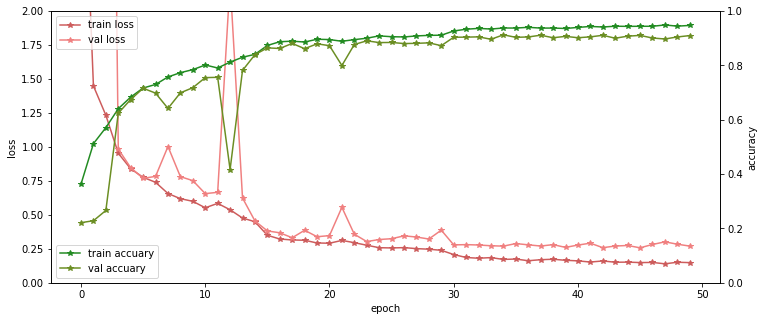

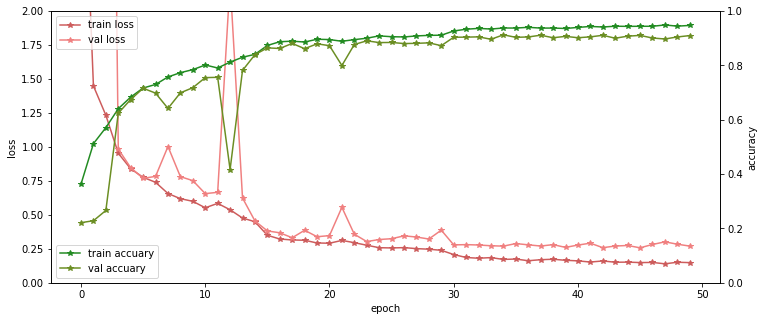

In [0]:
fig,loss_ax=plt.subplots(figsize=(12,5))
acc_ax=loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'indianred',marker='*',label='train loss')
loss_ax.plot(hist.history['val_loss'],'lightcoral',marker='*',label='val loss')

loss_ax.set_ylim([0, 2])


acc_ax.plot(hist.history['acc'],'forestgreen',marker='*',label='train accuary')
acc_ax.plot(hist.history['val_acc'],'olivedrab',marker='*',label='val accuary')
acc_ax.set_ylim([0, 1])


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
#아래 그래프에서 에폭 30때 val_acc가 급격한 상승을 한 것을 볼 수 있음.
#epoch=30 부터 lr을 0.0001로 학습한 결과.

In [0]:
from google.colab import files

In [0]:
files.download('best.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 54124, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
model.save_weights("model_weight.h5")
files.download("model_weight.h5")

model.save('wide_model.h5')
files.download("wide_model.h5")

In [0]:
model.load_weights('best_2.h5')

In [0]:
files.download("best_2.h5")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 58554, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:

result = model.predict(X_test,batch_size=64)
result = np.argmax(result,axis=1).reshape(-1,1)

output = pd.DataFrame(X_id)
output['pred_label'] = result
output.columns = ['id','pred_label']
output = output.set_index('id')

In [0]:
output.to_csv('prediction.csv')


files.download("prediction.csv")